In [1]:
import gensim.downloader as api
import time
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
import time
# from scipy.sparse import csr_matrix


import sys
sys.path += ['Package/']  

from word_embedding import * 

import warnings
warnings.filterwarnings("ignore")

directory_root = '/home/lorenzo/Scrivania/My_projects/DeepWalk/Codes/'

In [2]:
# load the data

dataset = api.load('text8')
text = [a for a in dataset]

# df = pd.read_csv('Bkp_vars/norm_enwik9')
# X = df.values
# del df
# # text = [x[0].split(' ') for x in X[:int(len(X)/3)]]
# text = [x[0].split(' ') for x in X]
# del X

In [3]:
dim = 64
n_epochs = 1
window_size = 5
min_count = 5
th = 1
η0 = 0.85
# ηfin = 0.3

t0 = time.time()
Φ, word2idx, P, d = WordEmbedding(text, dim = dim, n_epochs = n_epochs, window_size = window_size, min_count = min_count, th = th,  
        scheduler_type = 'constant', η0 = η0)

print('\n')
print(time.time() - t0)

Text pre-processing
Get the probability matrix


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    6.8s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    7.4s finished


Computing the embedding
Running the optimization for k = 1
[========================>] 100%

31.61001682281494


In [9]:
n = np.shape(P)[0]
f = 1/np.log(d+1)
n_epochs = 8
η0 = 0.5
# cumsum = np.array([np.sum(f <= i)/len(f) for i in np.arange(np.max(f))])
# th = np.min(np.arange(np.max(f))[cumsum > 0.95])
# f[f > th] = th
print('si comincia')

Φ = CreateEmbedding([P], f = f, dim = dim, n_epochs = n_epochs, n_prod = 1., sum_partials = False,
                  k = 1, verbose = True, cov_type = 'diag', scheduler_type = 'linear', η0 = η0)


si comincia
Running the optimization for k = 1


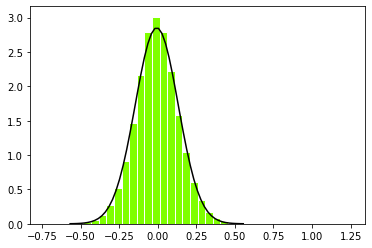

In [10]:
_, μ, σ2, π = computeZest(Φ, [0], k = 8, return_params = True, cov_type = 'full')

def Normal(μ, σ2, t):
    
    return 1/np.sqrt(2*np.pi*σ2)*np.exp(-(t - μ)**2/(2*σ2))

a = np.random.randint(P.shape[0])
m = np.mean(Φ[a]@Φ.T) 
s = np.sqrt(np.var(Φ[a]@Φ.T))
t = np.linspace(m - 4*s, m + 4*s)
n, dim = np.shape(Φ)    

y = np.sum(np.diag(π/n)@np.array([Normal(Φ[a]@μ[b], Φ[a]@σ2[b]@Φ[a], t) for b in range(len(μ))]), axis = 0)
plt.plot(t, y, color = 'k', label = 'Predicted')

plt.hist(Φ[a]@Φ.T, bins = 40, density = True, edgecolor = 'white', color = 'chartreuse')
plt.show();

In [11]:
t0 = time.time()
model = Word2Vec(sentences = text, vector_size = dim, negative = 5, window = window_size, 
                 min_count = min_count, workers = 8)
time.time() - t0

41.08515286445618

In [27]:
X = normalize(Φ, norm = 'l2', axis = 1)
how_many = 10
all_words = list(word2idx.keys())

word = 'gun'
idx = all_words.index(word)
similarity = X[idx]@X.T
idx = np.argsort(similarity)[::-1]
most_similar = np.array(all_words)[idx][1:how_many+1]
print("Our method:\n")
for m, s in zip(most_similar, similarity[idx][1:how_many+1]):
    print(tuple([m, s]))

print("\n-------------------------\n")
print("Gensim:\n")
for m in model.wv.most_similar(word):
    print(m)
    
Yd = np.array([model.wv.get_vector(w) for w in model.wv.key_to_index.keys()])
Y = (Yd.T - np.reshape(np.mean(Yd, axis = 0), (dim, 1))).T        
Y = normalize(Y, norm = 'l2', axis = 1)
        
words_gensim = [w for w in model.wv.key_to_index.keys()]

Our method:

('caliber', 0.8080020967440653)
('guns', 0.7996041240367353)
('smoothbore', 0.7262195866369773)
('gatling', 0.7107346172564074)
('weapon', 0.7091893225337371)
('pistols', 0.7006806934185711)
('rifles', 0.6984071482402796)
('rifled', 0.6836038489963723)
('barrel', 0.6740274527950145)
('shotguns', 0.6698004513895431)

-------------------------

Gensim:

('rifle', 0.8504845499992371)
('pistol', 0.8166509866714478)
('weapon', 0.8146999478340149)
('gatling', 0.7869135737419128)
('guns', 0.7815782427787781)
('submachine', 0.7659714818000793)
('ammunition', 0.7469615936279297)
('sniper', 0.7353842258453369)
('cannon', 0.7326434254646301)
('rifles', 0.7216576337814331)


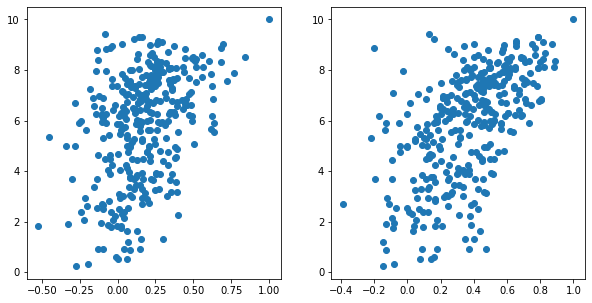

(0.4034140907087715, 3.607290585681673e-15)
(0.5824460818798203, 2.882849587908051e-33)

----------------
SpearmanrResult(correlation=0.3954777512322039, pvalue=1.3716752242178335e-14)
SpearmanrResult(correlation=0.6001473829753969, pvalue=1.0168217566813987e-35)

----------------
KendalltauResult(correlation=0.27265565514835605, pvalue=2.666006044370483e-14)
KendalltauResult(correlation=0.4264605732701924, pvalue=1.0700980464097384e-32)


In [24]:
sim = pd.read_csv('/home/lorenzo/Scrivania/My_projects/DeepWalk/Codes/versioni/P2Vec/data/wordsim353.tsv', header = None, sep = '\t')

os = []
w2vs = []
gts = []

for i in range(len(sim)):
    a = sim.iloc[i][0].lower()
    b = sim.iloc[i][1].lower()
    if (a in all_words) and (b in all_words):
        os.append(X[all_words.index(a)]@X[all_words.index(b)])
        w2vs.append(Y[words_gensim.index(a)]@Y[words_gensim.index(b)])
        gts.append(sim.iloc[i][2])
        
fig, ax = plt.subplots(1, 2, figsize = (10,5))

ax[0].scatter(os, gts)
ax[1].scatter(w2vs, gts)

plt.show();

from scipy.stats import pearsonr, spearmanr, kendalltau


print(pearsonr(os, gts))
print(pearsonr(w2vs, gts))

print("\n----------------")

print(spearmanr(os, gts))
print(spearmanr(w2vs, gts))

print("\n----------------")

print(kendalltau(os, gts))
print(kendalltau(w2vs, gts))